# Introduction

## Data

In [1]:
import pandas as pd
import numpy as np
import scipy.stats

%matplotlib inline 
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(12.0,8.0)})

df = pd.read_json('data.json')

# Transforming and ordering features
df = df.astype({'subtype':'category','grade':'category','host_response':'category'})
df['subtype'].cat.reorder_categories(['Usual','Basaloid','Warty','Warty-Basaloid','Papillary','Verrucous','Sarcomatoid'], inplace=True, ordered=False)
df['grade'].cat.reorder_categories(['Grade 1','Grade 2','Grade 3'], ordered=True, inplace=True)
df['host_response'].cat.reorder_categories(['No','Mild','Moderate','Intense'], ordered=True, inplace=True)

## Functions

### Exploratory data analysis

In [2]:
'''
Tables
'''
# Defining a function to create a pivot table
def create_pivot(rows, columns):
    tbl = df.groupby([columns, rows])['n'].count().astype('int').to_frame()
    tbl_pivot = pd.pivot_table(tbl, index=rows, columns=columns, values='n').fillna(0).astype('int')
    return tbl_pivot

# Defining a function to describe numeric variables
def create_descriptive(x):
    return df[x].describe().round().to_frame()

# Defining a function to provide grouped descritive statistics
def create_descriptives(x, group):
    return df.groupby(group)[x].describe().round()

'''
Plots
'''
# Barplot
def plot_bar(x, y):
    ax = sns.countplot(data=df, x=x, hue=y)

# Distribution plot
def plot_kde(x, bins=10):
    sns.distplot(df[x].dropna(), kde=False, bins=bins)
    plt.show()

# Boxenplot
def plot_box(x, group):
    ax = sns.boxenplot(data=df, x=group, y=x)

# Pointplot
def plot_point(x, group):
    ax = sns.pointplot(x=group, y=x, ci=None, estimator=np.median, data=df)
    
# Paoirplot
def plot_pair(vars):
    df_corr = df.loc[:,vars]
    df_corr.dropna(inplace=True)
    ax = sns.pairplot(df_corr)
    
'''
Tests
'''
# Chi-squared test
def do_chi2(rows, columns):
    tbl_pivot = create_pivot(rows, columns)
    chi2, p, dof, expected = scipy.stats.chi2_contingency(tbl_pivot)
    print('Chi2 statistic: %g\nDegrees of freedom: %g\nP value: %g' %(chi2, dof, p))

# Kruskal-Wallis test
def do_kw(x, group):
    stat, p = scipy.stats.kruskal(*[data[x].values for name, data in df.groupby(group)], nan_policy='omit')
    print('Kruskal-Wallis statistic: %g\nP value: %g' %(stat, p))

# Spearman correlation test, rho coefficients
def do_spearman_rho(vars):
    df_corr = df.loc[:,vars]
    df_corr.dropna(inplace=True)
    x = np.array(df_corr)
    x_cols = df_corr.columns
    rho, p = scipy.stats.spearmanr(x)
    return pd.DataFrame(rho, index=x_cols, columns=x_cols).round(2)

# Spearman correlation test, p values
def do_spearman_p(vars):
    df_corr = df.loc[:,vars]
    df_corr.dropna(inplace=True)
    x = np.array(df_corr)
    x_cols = df_corr.columns
    rho, p = scipy.stats.spearmanr(x)
    return pd.DataFrame(p, index=x_cols, columns=x_cols)

### Machine learning

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score

# Function to estimate the explained variance score
def get_scores(target, features):
    y = df_ml.loc[:,target]
    X = df_ml.loc[:,features]
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), features)], remainder='passthrough')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = ct.fit_transform(X_train)
    X_test = ct.transform(X_test)
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    var = explained_variance_score(y_test, y_pred)
    print('Variance explained by %s: %g' %(str(features), var*100))
    
# Function to return explained variance scores for pathologic features
def get_all_scores(target):
    features = ['subtype','grade','host_response',target]
    global df_ml
    df_ml = df.loc[:,features].dropna()
    get_scores(target, ['subtype'])
    get_scores(target, ['grade'])
    get_scores(target, ['host_response'])
    get_scores(target, ['subtype','grade'])
    get_scores(target, ['host_response','grade'])
    get_scores(target, ['subtype','host_response'])
    get_scores(target, ['subtype','grade','host_response'])

# Pathologic features

In [4]:
# Number of pathology cases
df['sp'].nunique()

108

In [5]:
# Number of TMA spots
df.shape[0]

528

## Histologic subtype

In [6]:
df.groupby('subtype')['sp'].nunique().sort_values(ascending=False).to_frame()

,sp
subtype,
Usual,45
Warty-Basaloid,24
Warty,16
Basaloid,11
Papillary,9
Verrucous,2
Sarcomatoid,1


## Histologic grade

In [7]:
# Counting spots per grade
df['grade'].value_counts(sort=False).to_frame()

,grade
Grade 1,51
Grade 2,191
Grade 3,262


## Host response

In [8]:
# Trasforming variable to be ordered
df['host_response'].value_counts(sort=False).to_frame()

,host_response
No,4
Mild,96
Moderate,154
Intense,250


## Association between pathologic features

### Histologic subtype and histologic grade

In [9]:
# Pivot table of subtype by grade
create_pivot('subtype', 'grade')

grade,Grade 1,Grade 2,Grade 3
subtype,,,
Usual,34,103,57
Basaloid,0,0,64
Warty,1,30,45
Warty-Basaloid,0,28,92
Papillary,13,26,1
Verrucous,3,4,0
Sarcomatoid,0,0,3


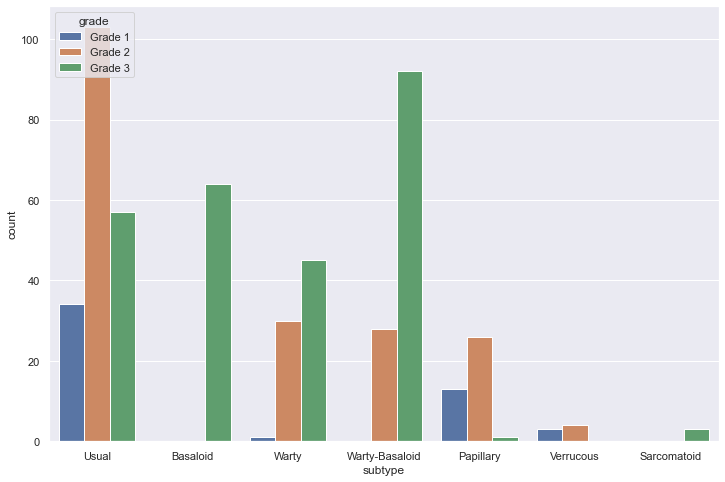

In [10]:
# Barplot of subtype by grade
plot_bar('subtype','grade')

In [11]:
# Association between subtype and grade
do_chi2('subtype','grade')

Chi2 statistic: 200.979
Degrees of freedom: 12
P value: 2.04809e-36


### Histologic subtype and host response

In [12]:
# Pivot table of subtype by host response
create_pivot('subtype','host_response')

host_response,No,Mild,Moderate,Intense
subtype,,,,
Usual,0,36,61,95
Basaloid,1,12,17,34
Warty,1,14,21,41
Warty-Basaloid,1,22,41,57
Papillary,1,7,14,18
Verrucous,0,5,0,2
Sarcomatoid,0,0,0,3


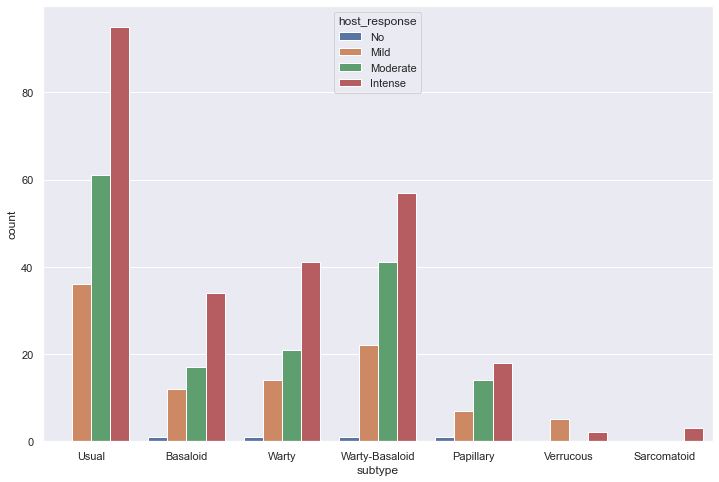

In [13]:
# barplot of subtype by host response
plot_bar('subtype','host_response')

In [14]:
# Association between subtype and host response
do_chi2('subtype','host_response')

Chi2 statistic: 21.8924
Degrees of freedom: 18
P value: 0.236796


### Histologic grade and host response

In [15]:
# Pivot table pf grade by host response
create_pivot('grade','host_response')

host_response,No,Mild,Moderate,Intense
grade,,,,
Grade 1,1,15,18,17
Grade 2,1,36,59,93
Grade 3,2,45,74,137


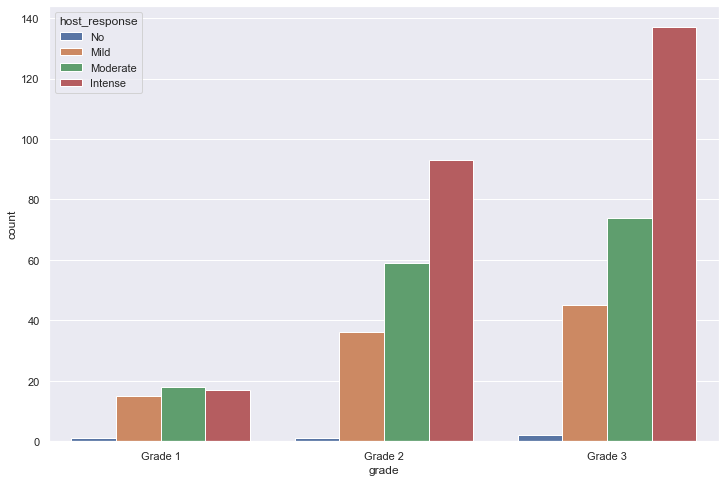

In [16]:
# Barplot of grade by host response
plot_bar('grade','host_response')

In [17]:
# Association between grade and host response
do_chi2('grade','host_response')

Chi2 statistic: 8.26221
Degrees of freedom: 6
P value: 0.219515


# PD-L1

PD-L1 expression was measured in tumor cells (percentage of positive cells and H-score) and in intratumoral lymphocytes (number of positive cells).

## Overall expression

### Tumor cells (%)

In [18]:
create_descriptive('pdl1_tumor')

,pdl1_tumor
count,504.0
mean,26.0
std,34.0
min,0.0
25%,0.0
50%,5.0
75%,40.0
max,100.0


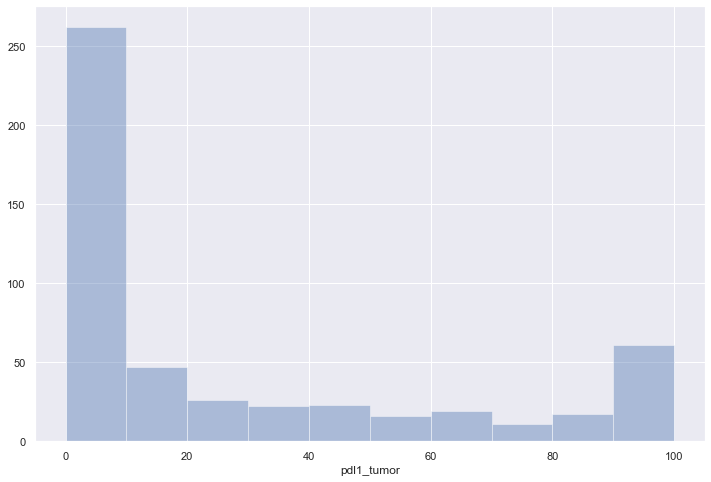

In [19]:
plot_kde('pdl1_tumor')

In [20]:
pdl1_tumor_pos1 = df['pdl1_tumor'].apply(lambda x: 'Positive' if x > 0 else 'Negative')
pdl1_tumor_pos1.value_counts().to_frame()

,pdl1_tumor
Positive,331
Negative,197


In [21]:
df['pdl1_tumor_location'].value_counts().to_frame()

,pdl1_tumor_location
Cytoplasmic/Membraneous,250
Cytplasmic,81


### Tumor cells (H-score)

In [22]:
create_descriptive('pdl1_tumor_h')

,pdl1_tumor_h
count,504.0
mean,36.0
std,60.0
min,0.0
25%,0.0
50%,5.0
75%,50.0
max,300.0


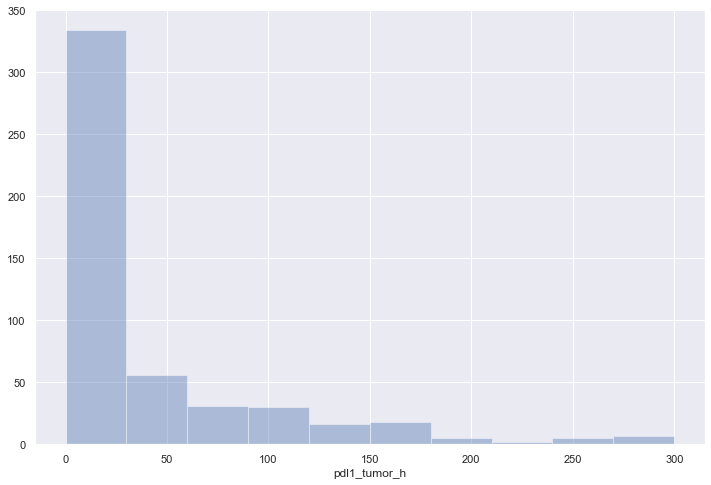

In [23]:
plot_kde('pdl1_tumor_h')

### Intratumoral lymphocytes

In [24]:
create_descriptive('pdl1_lymph')

,pdl1_lymph
count,497.0
mean,7.0
std,10.0
min,0.0
25%,1.0
50%,5.0
75%,10.0
max,70.0


<AxesSubplot:xlabel='pdl1_lymph'>

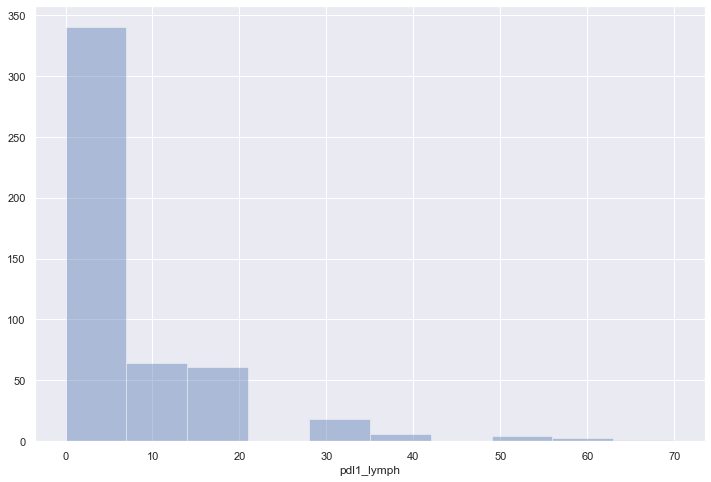

In [25]:
sns.distplot(df['pdl1_lymph'], kde=False, bins=10)

## Histologic subtype

### Tumor cells (%)

In [26]:
create_descriptives('pdl1_tumor','subtype')

,count,mean,std,min,25%,50%,75%,max
subtype,,,,,,,,
Usual,192.0,25.0,35.0,0.0,0.0,5.0,50.0,100.0
Basaloid,64.0,32.0,32.0,0.0,0.0,25.0,50.0,100.0
Warty,77.0,15.0,23.0,0.0,0.0,5.0,20.0,90.0
Warty-Basaloid,121.0,37.0,39.0,0.0,2.0,20.0,80.0,100.0
Papillary,40.0,1.0,4.0,0.0,0.0,0.0,0.0,20.0
Verrucous,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sarcomatoid,3.0,100.0,0.0,100.0,100.0,100.0,100.0,100.0


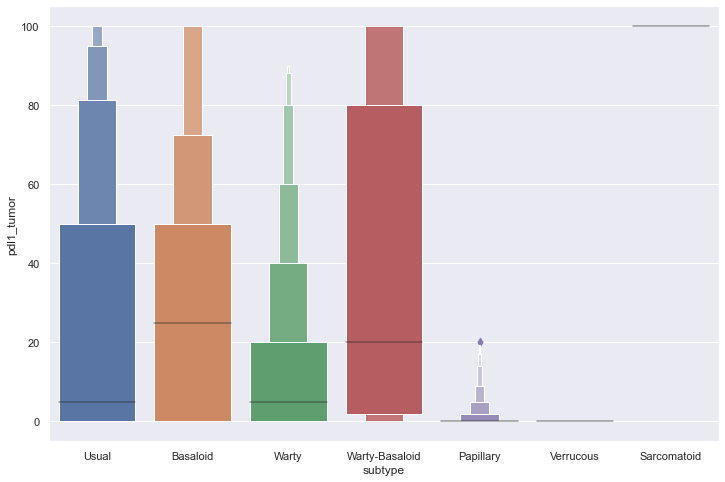

In [27]:
plot_box('pdl1_tumor', 'subtype')

In [28]:
do_kw('pdl1_tumor', 'subtype')

Kruskal-Wallis statistic: 77.2567
P value: 1.31578e-14


### Tumor cells (H-score)

In [29]:
create_descriptives('pdl1_tumor_h','subtype')

,count,mean,std,min,25%,50%,75%,max
subtype,,,,,,,,
Usual,192.0,38.0,60.0,0.0,0.0,5.0,56.0,280.0
Basaloid,64.0,36.0,39.0,0.0,0.0,28.0,50.0,150.0
Warty,77.0,16.0,25.0,0.0,0.0,5.0,20.0,100.0
Warty-Basaloid,121.0,55.0,71.0,0.0,2.0,20.0,90.0,300.0
Papillary,40.0,1.0,5.0,0.0,0.0,0.0,0.0,25.0
Verrucous,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sarcomatoid,3.0,293.0,12.0,280.0,290.0,300.0,300.0,300.0


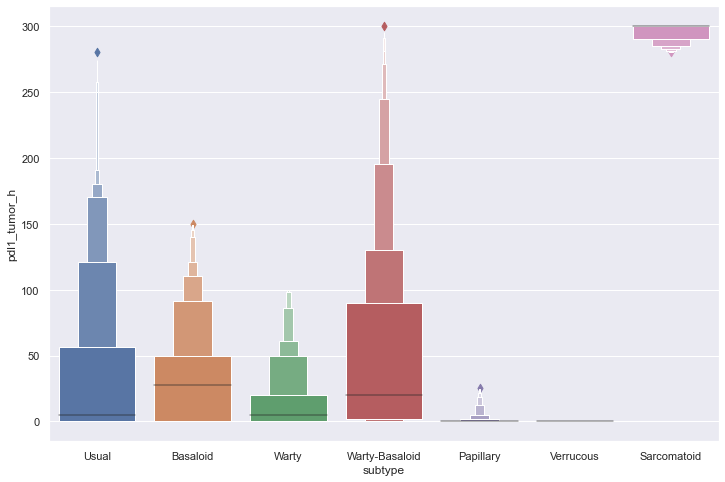

In [30]:
plot_box('pdl1_tumor_h','subtype')

In [31]:
do_kw('pdl1_tumor_h','subtype')

Kruskal-Wallis statistic: 76.2364
P value: 2.13539e-14


### Intratumoral lymphocytes

In [32]:
create_descriptives('pdl1_lymph','subtype')

,count,mean,std,min,25%,50%,75%,max
subtype,,,,,,,,
Usual,192.0,9.0,12.0,0.0,1.0,5.0,10.0,70.0
Basaloid,63.0,9.0,12.0,0.0,2.0,5.0,10.0,60.0
Warty,75.0,6.0,9.0,0.0,0.0,5.0,6.0,40.0
Warty-Basaloid,120.0,6.0,8.0,0.0,1.0,5.0,10.0,50.0
Papillary,37.0,3.0,4.0,0.0,0.0,2.0,5.0,20.0
Verrucous,7.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
Sarcomatoid,3.0,18.0,10.0,10.0,12.0,15.0,22.0,30.0


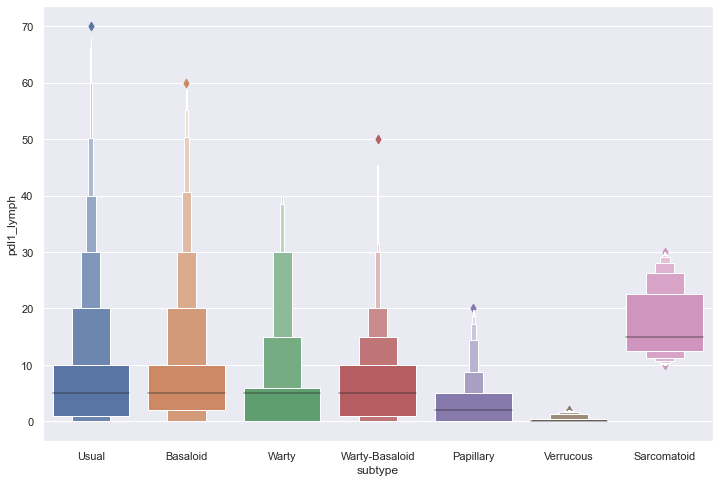

In [33]:
plot_box('pdl1_lymph','subtype')

In [34]:
do_kw('pdl1_lymph','subtype')

Kruskal-Wallis statistic: 29.7604
P value: 4.36519e-05


## Histologic grade

### Tumor cells (%)

In [35]:
create_descriptives('pdl1_tumor','grade')

,count,mean,std,min,25%,50%,75%,max
grade,,,,,,,,
Grade 1,51.0,8.0,21.0,0.0,0.0,0.0,5.0,90.0
Grade 2,189.0,21.0,34.0,0.0,0.0,1.0,30.0,100.0
Grade 3,258.0,32.0,36.0,0.0,1.0,15.0,60.0,100.0


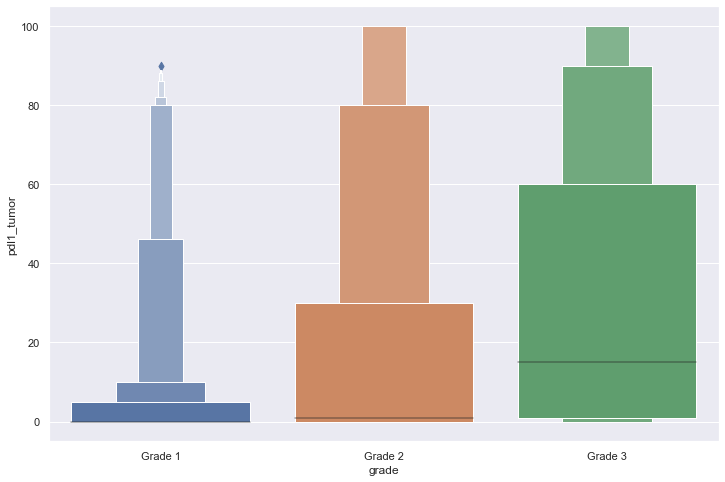

In [36]:
plot_box('pdl1_tumor','grade')

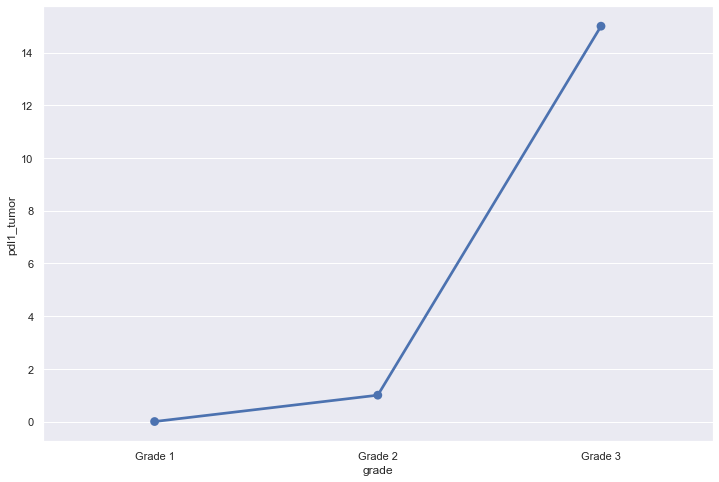

In [37]:
plot_point('pdl1_tumor','grade')

In [38]:
do_kw('pdl1_tumor','grade')

Kruskal-Wallis statistic: 45.0078
P value: 1.6853e-10


### Tumor cells (H-score)

In [39]:
create_descriptives('pdl1_tumor_h','grade')

,count,mean,std,min,25%,50%,75%,max
grade,,,,,,,,
Grade 1,51.0,12.0,35.0,0.0,0.0,0.0,5.0,160.0
Grade 2,189.0,29.0,51.0,0.0,0.0,1.0,35.0,250.0
Grade 3,258.0,47.0,67.0,0.0,1.0,18.0,64.0,300.0


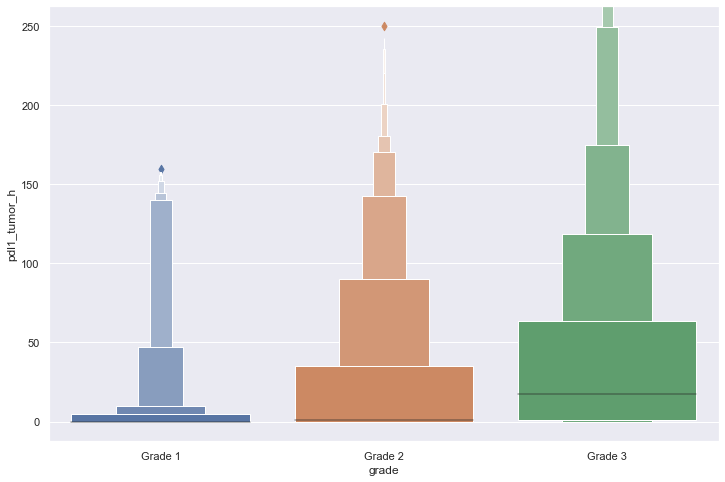

In [40]:
plot_box('pdl1_tumor_h','grade')

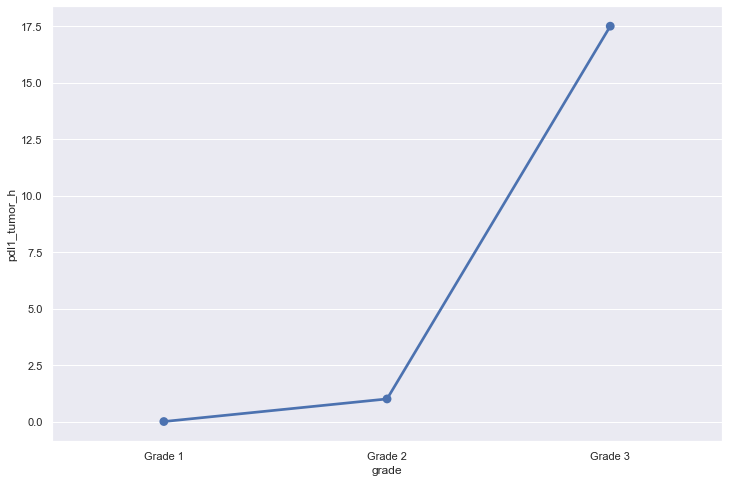

In [41]:
plot_point('pdl1_tumor_h','grade')

In [42]:
do_kw('pdl1_tumor_h','grade')

Kruskal-Wallis statistic: 44.1817
P value: 2.54727e-10


### Intratumoral lymphocytes

In [43]:
create_descriptives('pdl1_lymph','grade')

,count,mean,std,min,25%,50%,75%,max
grade,,,,,,,,
Grade 1,48.0,9.0,14.0,0.0,1.0,2.0,6.0,60.0
Grade 2,187.0,6.0,9.0,0.0,0.0,2.0,8.0,60.0
Grade 3,256.0,8.0,11.0,0.0,1.0,5.0,10.0,70.0


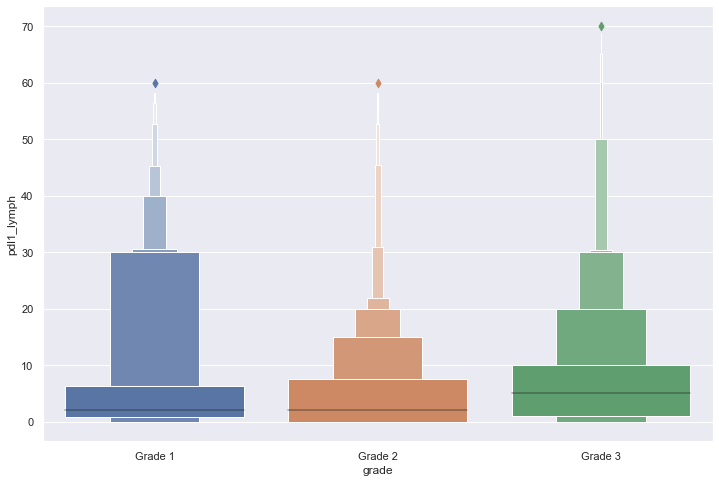

In [44]:
plot_box('pdl1_lymph','grade')

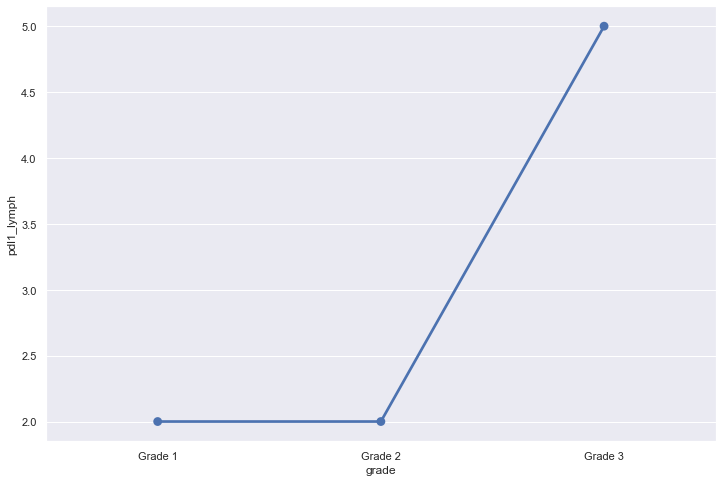

In [45]:
plot_point('pdl1_lymph','grade')

In [46]:
do_kw('pdl1_lymph','grade')

Kruskal-Wallis statistic: 8.57222
P value: 0.0137584


## Host response

### Tumor cells (%)

In [47]:
create_descriptives('pdl1_tumor','host_response')

,count,mean,std,min,25%,50%,75%,max
host_response,,,,,,,,
No,4.0,25.0,50.0,0.0,0.0,0.0,25.0,100.0
Mild,96.0,16.0,27.0,0.0,0.0,1.0,20.0,100.0
Moderate,154.0,19.0,30.0,0.0,0.0,2.0,20.0,100.0
Intense,250.0,34.0,37.0,0.0,0.0,15.0,60.0,100.0


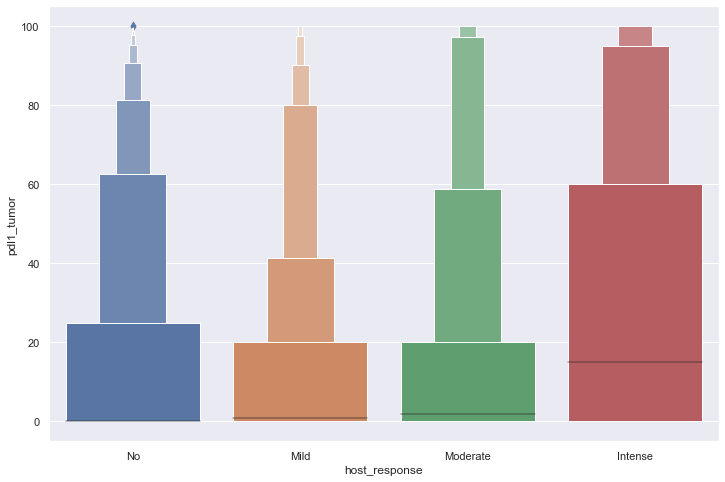

In [48]:
plot_box('pdl1_tumor','host_response')

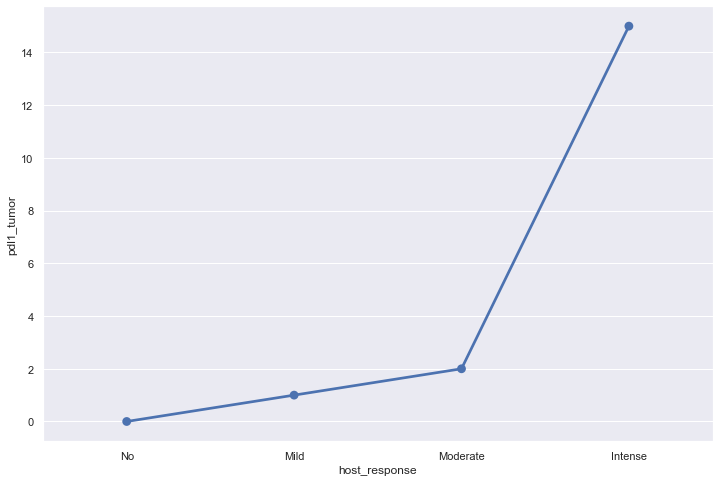

In [49]:
plot_point('pdl1_tumor','host_response')

In [50]:
do_kw('pdl1_tumor','host_response')

Kruskal-Wallis statistic: 26.7672
P value: 6.58739e-06


### Tumor cells (H-score)

In [51]:
create_descriptives('pdl1_tumor_h','host_response')

,count,mean,std,min,25%,50%,75%,max
host_response,,,,,,,,
No,4.0,75.0,150.0,0.0,0.0,0.0,75.0,300.0
Mild,96.0,20.0,36.0,0.0,0.0,1.0,20.0,150.0
Moderate,154.0,26.0,51.0,0.0,0.0,2.0,26.0,280.0
Intense,250.0,49.0,66.0,0.0,0.0,18.0,80.0,300.0


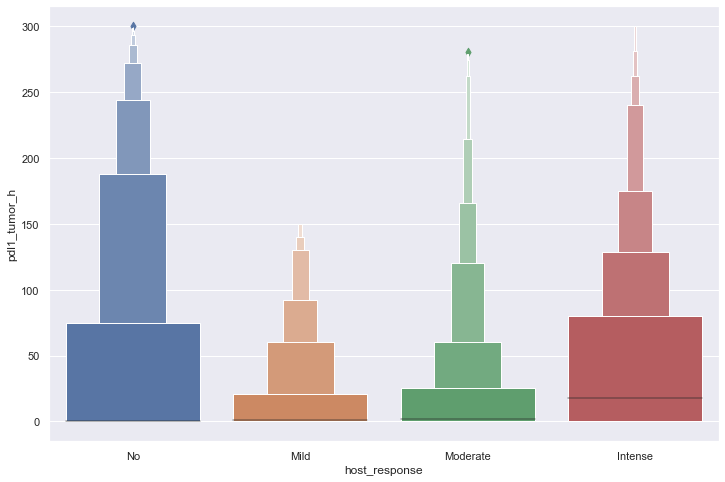

In [52]:
plot_box('pdl1_tumor_h','host_response')

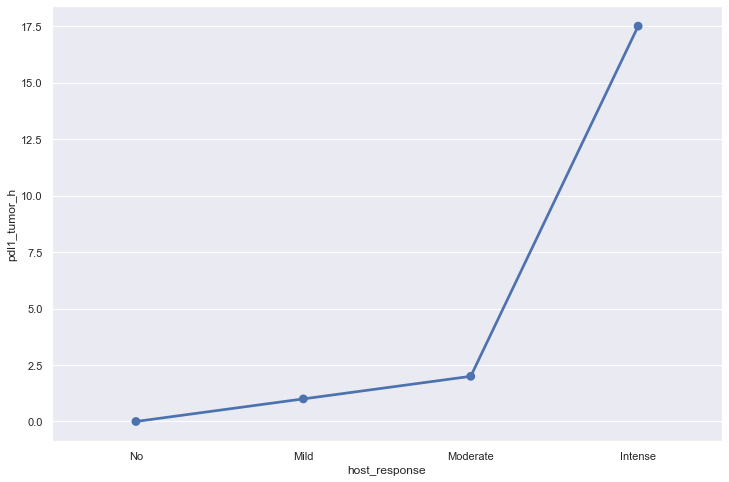

In [53]:
plot_point('pdl1_tumor_h','host_response')

In [54]:
do_kw('pdl1_tumor_h','host_response')

Kruskal-Wallis statistic: 26.1745
P value: 8.76797e-06


### Intratumoral lymphocytes

In [55]:
create_descriptives('pdl1_lymph','host_response')

,count,mean,std,min,25%,50%,75%,max
host_response,,,,,,,,
No,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mild,93.0,4.0,10.0,0.0,0.0,1.0,2.0,70.0
Moderate,154.0,4.0,5.0,0.0,1.0,2.0,5.0,30.0
Intense,250.0,11.0,12.0,0.0,2.0,5.0,15.0,60.0


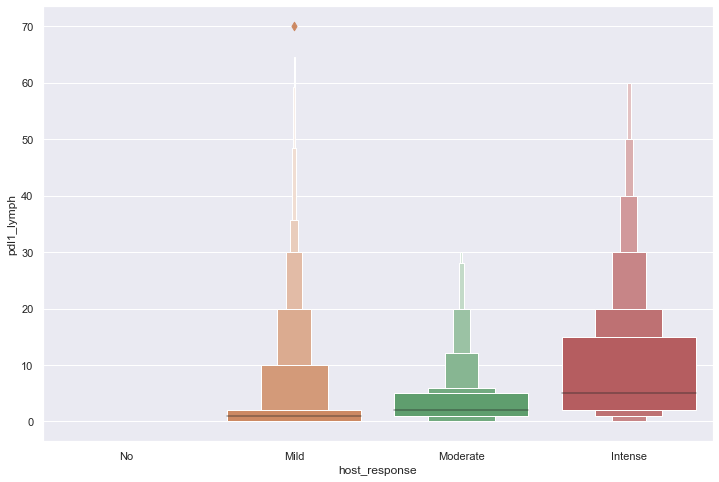

In [56]:
plot_box('pdl1_lymph','host_response')

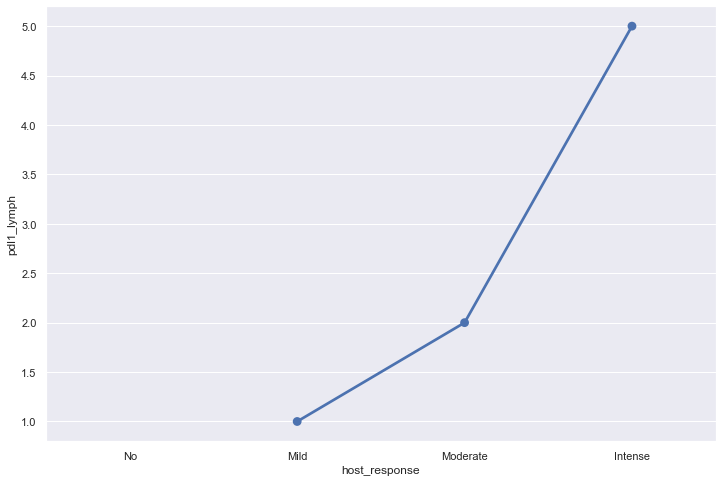

In [57]:
plot_point('pdl1_lymph','host_response')

In [58]:
do_kw('pdl1_lymph','host_response')

Kruskal-Wallis statistic: 89.7395
P value: 2.49182e-19


## Correlation matrix

In [59]:
vars = ['pdl1_tumor','pdl1_tumor_h','pdl1_lymph']

### Pairplot

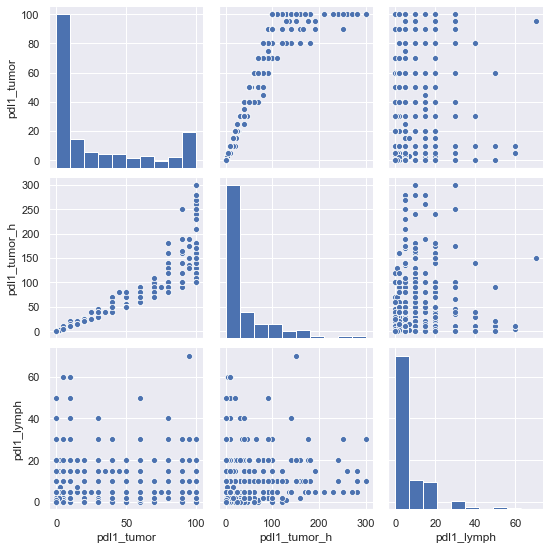

In [60]:
plot_pair(vars)

### Correlation coefficients

In [61]:
do_spearman_rho(vars)

,pdl1_tumor,pdl1_tumor_h,pdl1_lymph
pdl1_tumor,1.00,1.00,0.47
pdl1_tumor_h,1.00,1.00,0.48
pdl1_lymph,0.47,0.48,1.00


### P values

In [62]:
do_spearman_p(vars)

,pdl1_tumor,pdl1_tumor_h,pdl1_lymph
pdl1_tumor,0.000000e+00,0.000000e+00,2.545391e-29
pdl1_tumor_h,0.000000e+00,0.000000e+00,1.168989e-29
pdl1_lymph,2.545391e-29,1.168989e-29,0.000000e+00


## Impact of pathologic features

### Tumor cells (%)

In [63]:
get_all_scores('pdl1_tumor')

Variance explained by ['subtype']: 13.4973
Variance explained by ['grade']: 3.5085
Variance explained by ['host_response']: 6.52007
Variance explained by ['subtype', 'grade']: 9.01939
Variance explained by ['host_response', 'grade']: 9.56603
Variance explained by ['subtype', 'host_response']: 19.9779
Variance explained by ['subtype', 'grade', 'host_response']: 16.2733


### Tumor cells (H-score)

In [64]:
get_all_scores('pdl1_tumor_h')

Variance explained by ['subtype']: 8.69766
Variance explained by ['grade']: 0.923613
Variance explained by ['host_response']: 3.40178
Variance explained by ['subtype', 'grade']: 4.07026
Variance explained by ['host_response', 'grade']: 4.12818
Variance explained by ['subtype', 'host_response']: 12.9631
Variance explained by ['subtype', 'grade', 'host_response']: 8.82119


### Intratumoral lymphocytes

In [65]:
get_all_scores('pdl1_lymph')

Variance explained by ['subtype']: 4.09562
Variance explained by ['grade']: 2.50952
Variance explained by ['host_response']: 11.2489
Variance explained by ['subtype', 'grade']: 5.60741
Variance explained by ['host_response', 'grade']: 14.162
Variance explained by ['subtype', 'host_response']: 13.9136
Variance explained by ['subtype', 'grade', 'host_response']: 16.3493


# CD8 and Ki67

## Overall expression

### CD8 in intratumoral lymphocytes

In [66]:
create_descriptive('cd8_intratumoral')

,cd8_intratumoral
count,506.0
mean,10.0
std,16.0
min,0.0
25%,0.0
50%,4.0
75%,12.0
max,120.0


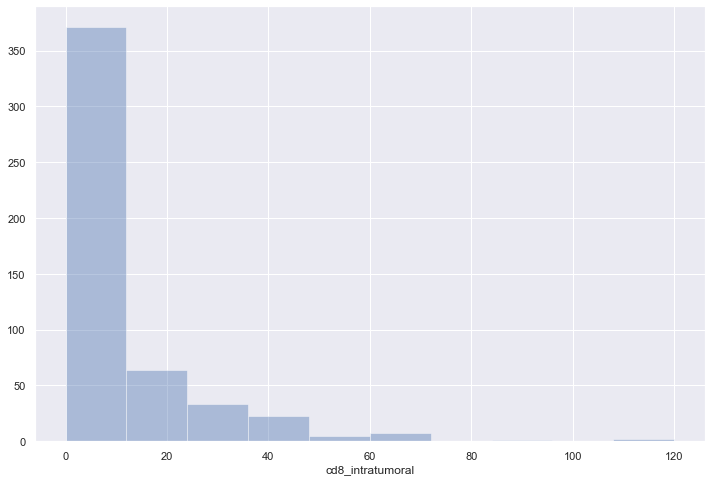

In [67]:
plot_kde('cd8_intratumoral')

We observed a mean of 10 CD8+ intratumoral lymphocytes per spot (standard deviation of 16 CD8+ lymphocytes, with a range from 0 to 120 CD8+ lymphocytes). Most of spots showed a low count of CD8+ intratumoral lymphocytes, with 50% of spots showing 4 or less CD8+ lymphocytes and 75% of spots showing 12 or less CD8+ positive lymphocytes.

### CD8-Ki67 in intratumoral lymphocytes

In [68]:
create_descriptive('cd8ki67_intratumoral')

,cd8ki67_intratumoral
count,506.0
mean,1.0
std,2.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,19.0


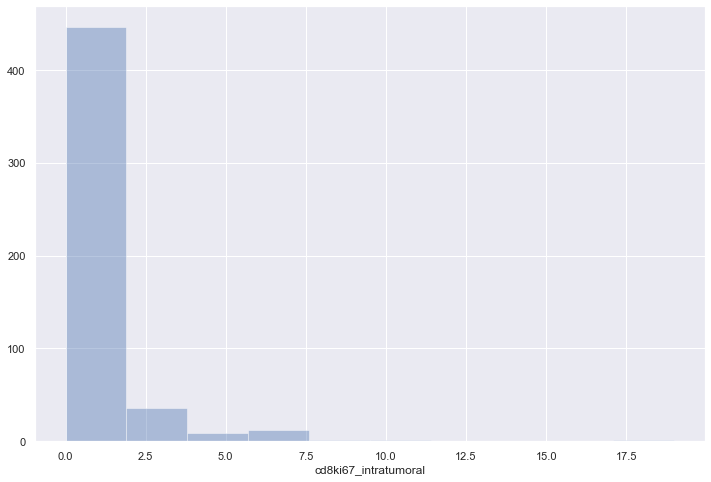

In [69]:
plot_kde('cd8ki67_intratumoral')

### CD8 in peritumoral lymphocytes

In [70]:
create_descriptive('cd8_peritumoral')

,cd8_peritumoral
count,503.0
mean,27.0
std,27.0
min,0.0
25%,5.0
50%,19.0
75%,40.0
max,150.0


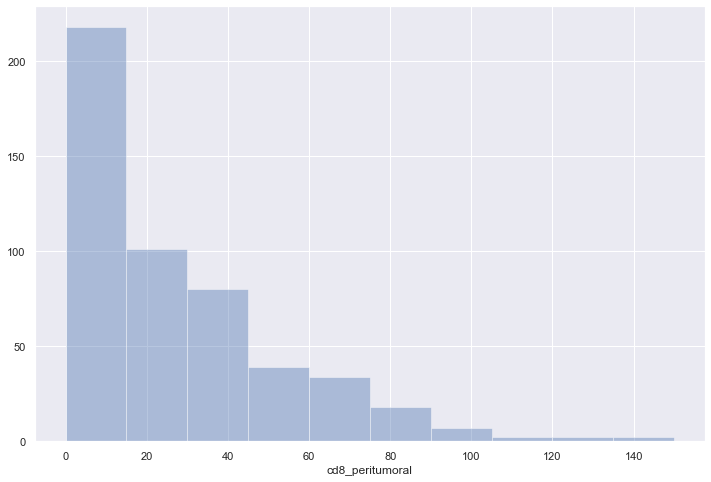

In [71]:
plot_kde('cd8_peritumoral')

### CD8-Ki67 in peritumoral lymphocytes

In [72]:
create_descriptive('cd8ki67_peritumoral')

,cd8ki67_peritumoral
count,501.0
mean,1.0
std,2.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,23.0


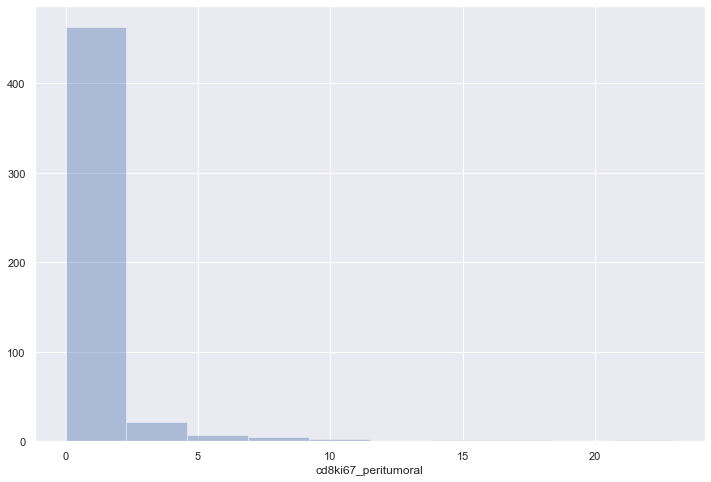

In [73]:
plot_kde('cd8ki67_peritumoral')

## Histologic subtype

### CD8 in intratumoral lymphocytes

In [74]:
create_descriptives('cd8_intratumoral', 'subtype')

,count,mean,std,min,25%,50%,75%,max
subtype,,,,,,,,
Usual,197.0,12.0,19.0,0.0,0.0,6.0,16.0,120.0
Basaloid,62.0,11.0,15.0,0.0,1.0,6.0,12.0,60.0
Warty,78.0,5.0,12.0,0.0,0.0,2.0,5.0,65.0
Warty-Basaloid,117.0,11.0,14.0,0.0,0.0,6.0,16.0,63.0
Papillary,42.0,6.0,8.0,0.0,0.0,4.0,9.0,32.0
Verrucous,7.0,2.0,3.0,0.0,0.0,0.0,2.0,9.0
Sarcomatoid,3.0,5.0,2.0,3.0,4.0,6.0,6.0,7.0


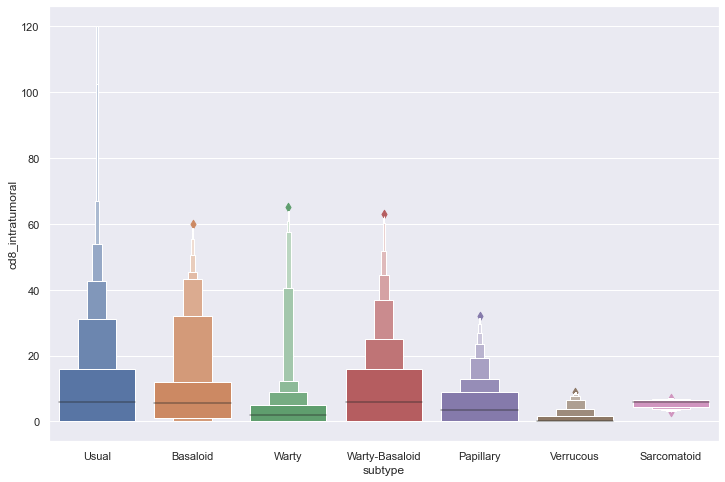

In [75]:
plot_box('cd8_intratumoral', 'subtype')

In [76]:
do_kw('cd8_intratumoral', 'subtype')

Kruskal-Wallis statistic: 22.9353
P value: 0.000818443


### CD8-Ki67 in intratumoral lymphocytes

In [77]:
create_descriptives('cd8ki67_intratumoral', 'subtype')

,count,mean,std,min,25%,50%,75%,max
subtype,,,,,,,,
Usual,197.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0
Basaloid,62.0,1.0,2.0,0.0,0.0,0.0,1.0,8.0
Warty,78.0,1.0,1.0,0.0,0.0,0.0,0.0,6.0
Warty-Basaloid,117.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0
Papillary,42.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
Verrucous,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sarcomatoid,3.0,10.0,8.0,6.0,6.0,6.0,12.0,19.0


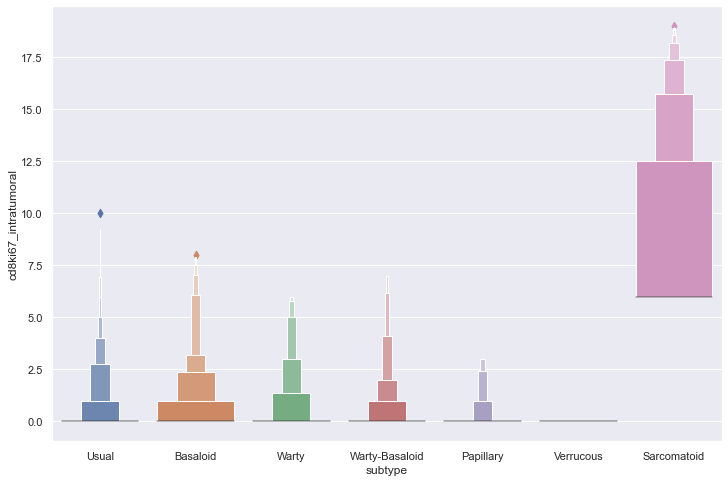

In [78]:
plot_box('cd8ki67_intratumoral', 'subtype')

In [79]:
do_kw('cd8ki67_intratumoral', 'subtype')

Kruskal-Wallis statistic: 29.5362
P value: 4.81465e-05


### CD8 in peritumoral lymphocytes

In [80]:
create_descriptives('cd8_peritumoral', 'subtype')

,count,mean,std,min,25%,50%,75%,max
subtype,,,,,,,,
Usual,198.0,29.0,29.0,0.0,7.0,22.0,43.0,150.0
Basaloid,59.0,25.0,20.0,0.0,10.0,19.0,36.0,75.0
Warty,78.0,22.0,25.0,0.0,0.0,14.0,34.0,101.0
Warty-Basaloid,116.0,27.0,27.0,0.0,4.0,20.0,42.0,116.0
Papillary,42.0,28.0,30.0,0.0,1.0,20.0,43.0,98.0
Verrucous,7.0,14.0,13.0,0.0,0.0,23.0,24.0,26.0
Sarcomatoid,3.0,12.0,6.0,5.0,10.0,14.0,16.0,17.0


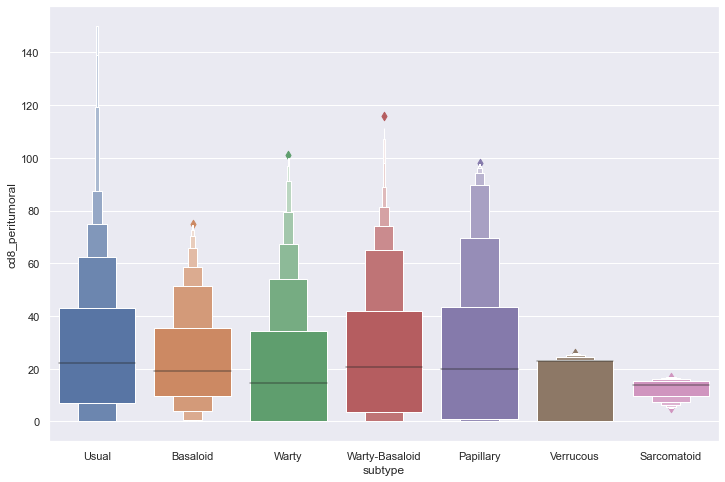

In [81]:
plot_box('cd8_peritumoral', 'subtype')

In [82]:
do_kw('cd8_peritumoral', 'subtype')

Kruskal-Wallis statistic: 7.42373
P value: 0.283431


### CD8-Ki67 in peritumoral lymphocytes

In [83]:
create_descriptives('cd8ki67_peritumoral', 'subtype')

,count,mean,std,min,25%,50%,75%,max
subtype,,,,,,,,
Usual,197.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0
Basaloid,59.0,1.0,3.0,0.0,0.0,0.0,0.0,17.0
Warty,77.0,1.0,2.0,0.0,0.0,0.0,0.0,8.0
Warty-Basaloid,116.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0
Papillary,42.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0
Verrucous,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sarcomatoid,3.0,16.0,7.0,10.0,12.0,14.0,18.0,23.0


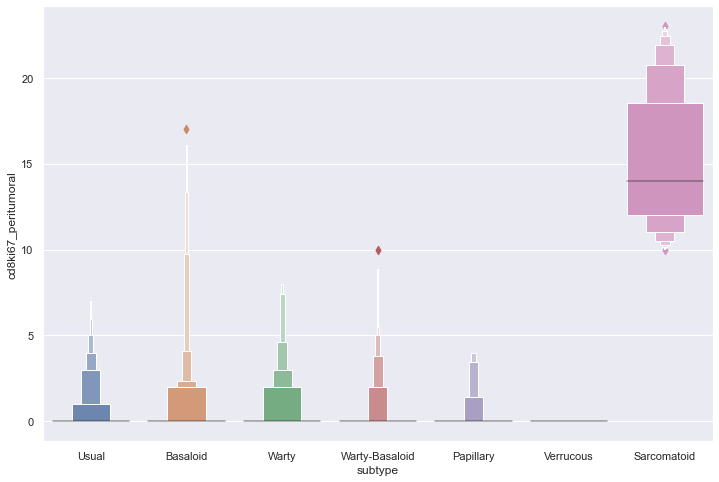

In [84]:
plot_box('cd8ki67_peritumoral', 'subtype')

In [85]:
do_kw('cd8ki67_peritumoral', 'subtype')

Kruskal-Wallis statistic: 28.2881
P value: 8.29192e-05


## Histologic grade

### CD8 in intratumoral lymphocytes

In [86]:
create_descriptives('cd8_intratumoral','grade')

,count,mean,std,min,25%,50%,75%,max
grade,,,,,,,,
Grade 1,50.0,6.0,10.0,0.0,0.0,1.0,9.0,46.0
Grade 2,188.0,8.0,12.0,0.0,0.0,2.0,10.0,58.0
Grade 3,256.0,13.0,18.0,0.0,1.0,6.0,15.0,120.0


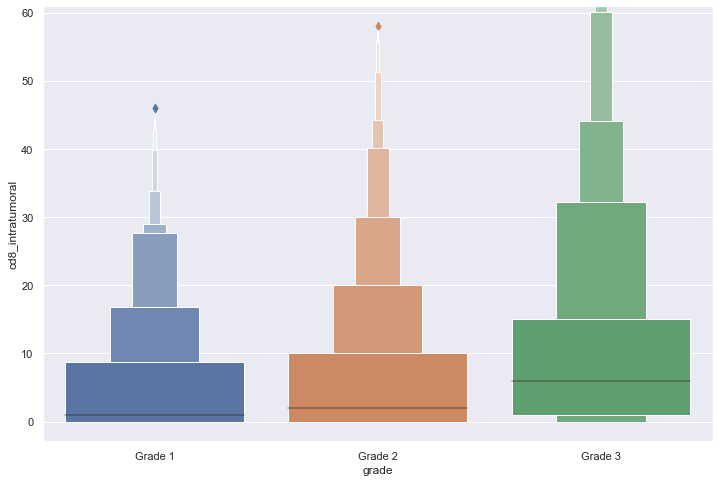

In [87]:
plot_box('cd8_intratumoral','grade')

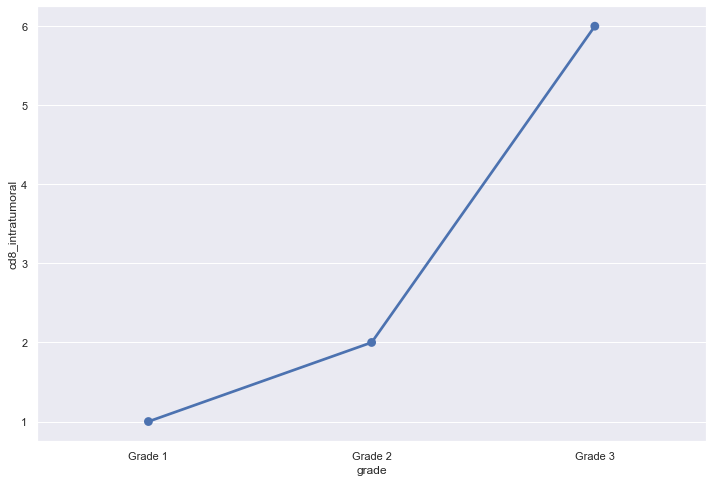

In [88]:
plot_point('cd8_intratumoral','grade')

In [89]:
do_kw('cd8_intratumoral','grade')

Kruskal-Wallis statistic: 23.1739
P value: 9.28663e-06


### CD8-Ki67 in intratumoral lymphocytes

In [90]:
create_descriptives('cd8ki67_intratumoral','grade')

,count,mean,std,min,25%,50%,75%,max
grade,,,,,,,,
Grade 1,50.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0
Grade 2,188.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0
Grade 3,256.0,1.0,2.0,0.0,0.0,0.0,0.0,19.0


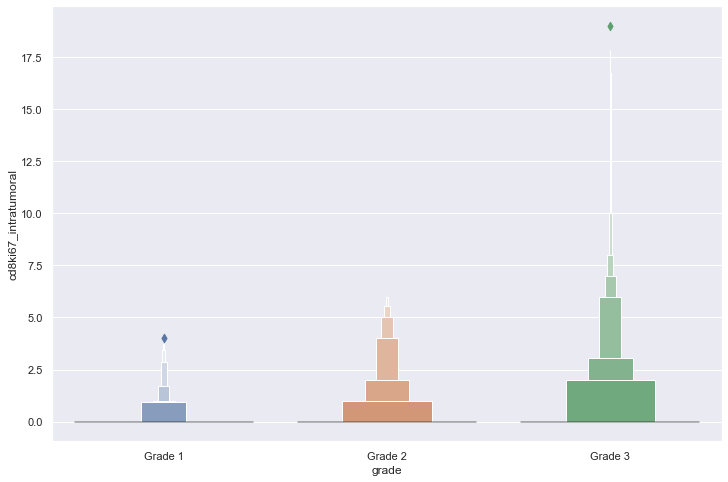

In [91]:
plot_box('cd8ki67_intratumoral','grade')

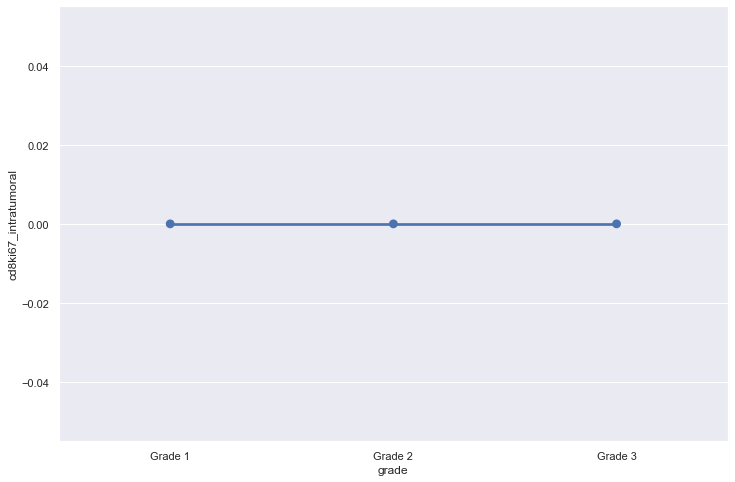

In [92]:
plot_point('cd8ki67_intratumoral','grade')

In [93]:
do_kw('cd8ki67_intratumoral','grade')

Kruskal-Wallis statistic: 13.7238
P value: 0.00104694


### CD8 in peritumoral lymphocytes

In [94]:
create_descriptives('cd8_peritumoral','grade')

,count,mean,std,min,25%,50%,75%,max
grade,,,,,,,,
Grade 1,50.0,26.0,23.0,0.0,7.0,24.0,40.0,95.0
Grade 2,190.0,28.0,30.0,0.0,4.0,16.0,44.0,150.0
Grade 3,245.0,25.0,24.0,0.0,5.0,19.0,40.0,150.0


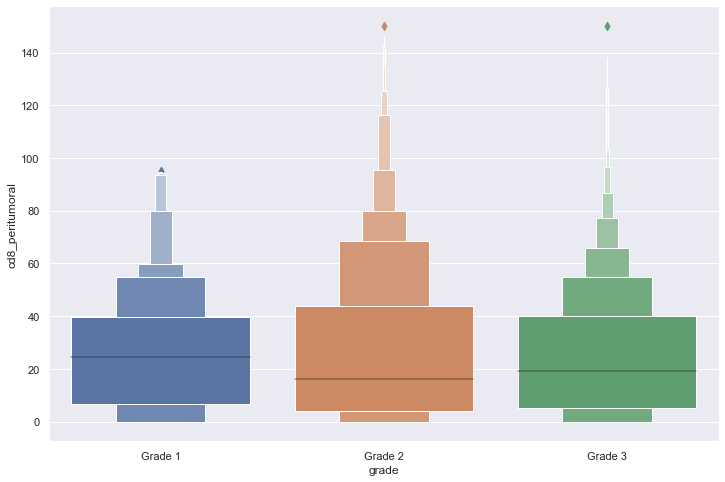

In [95]:
plot_box('cd8_peritumoral','grade')

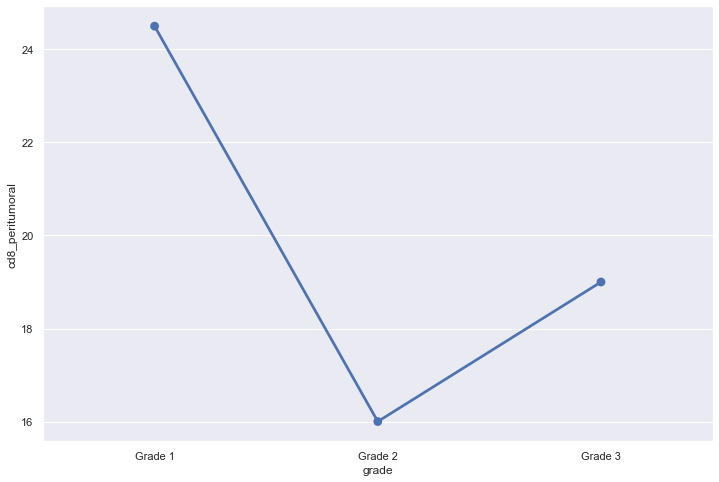

In [96]:
plot_point('cd8_peritumoral','grade')

In [97]:
do_kw('cd8_peritumoral','grade')

Kruskal-Wallis statistic: 0.170261
P value: 0.918392


### CD8-Ki67 in peritumoral lymphocytes

In [98]:
create_descriptives('cd8ki67_peritumoral','grade')

,count,mean,std,min,25%,50%,75%,max
grade,,,,,,,,
Grade 1,50.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0
Grade 2,190.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0
Grade 3,244.0,1.0,3.0,0.0,0.0,0.0,0.0,23.0


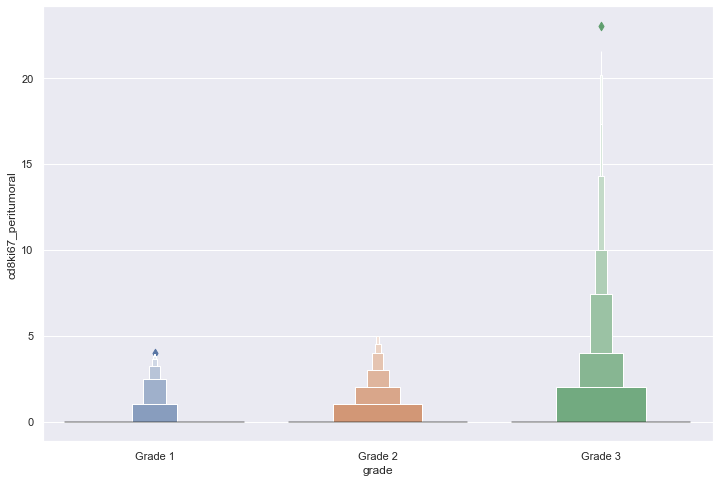

In [99]:
plot_box('cd8ki67_peritumoral','grade')

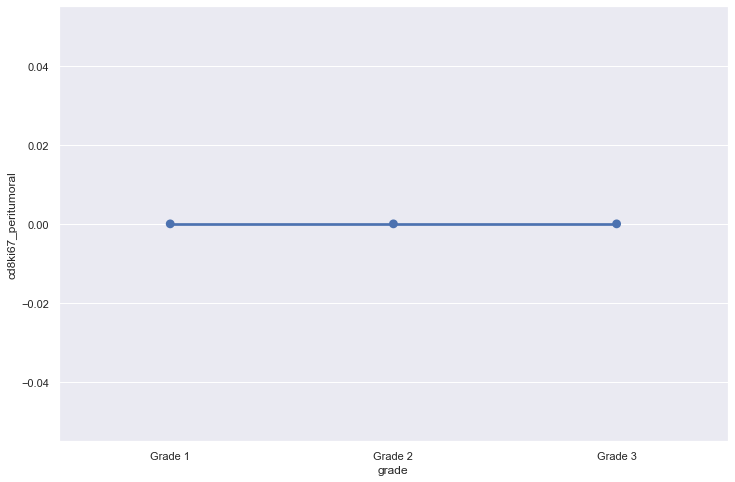

In [100]:
plot_point('cd8ki67_peritumoral','grade')

In [101]:
do_kw('cd8ki67_peritumoral','grade')

Kruskal-Wallis statistic: 5.80726
P value: 0.0548237


## Host response

### CD8 in intratumoral lymphocytes

In [102]:
create_descriptives('cd8_intratumoral','host_response')

,count,mean,std,min,25%,50%,75%,max
host_response,,,,,,,,
No,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mild,96.0,5.0,9.0,0.0,0.0,2.0,5.0,46.0
Moderate,151.0,7.0,12.0,0.0,0.0,2.0,10.0,62.0
Intense,243.0,14.0,19.0,0.0,1.0,8.0,20.0,120.0


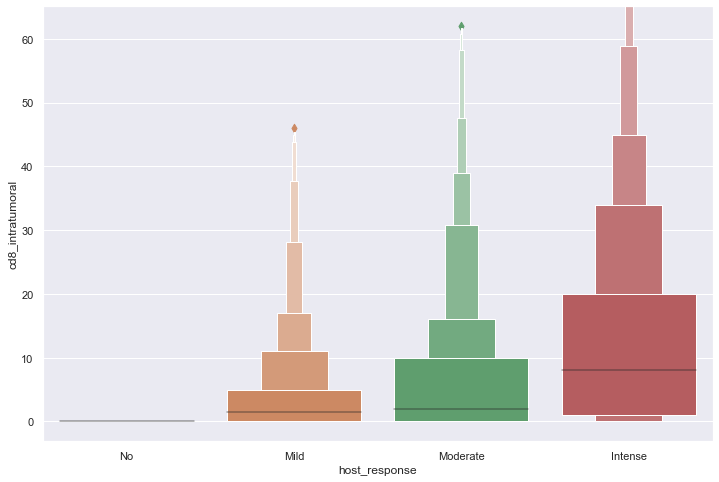

In [103]:
plot_box('cd8_intratumoral','host_response')

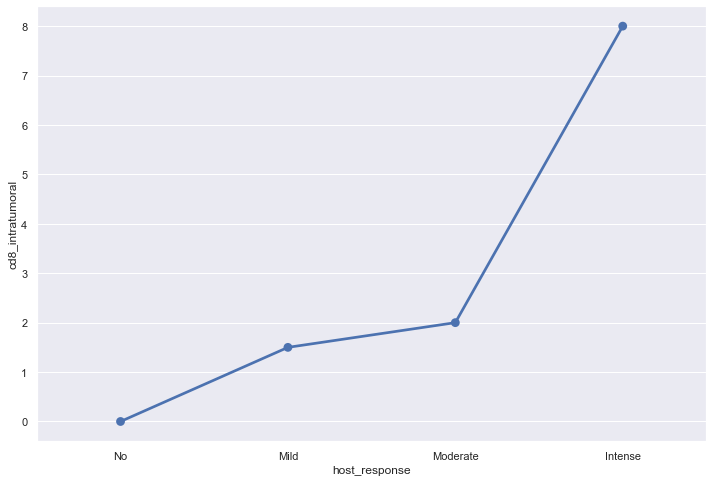

In [104]:
plot_point('cd8_intratumoral','host_response')

In [105]:
do_kw('cd8_intratumoral','host_response')

Kruskal-Wallis statistic: 46.5498
P value: 4.33289e-10


### CD8 in intratumoral lymphocytes

In [106]:
create_descriptives('cd8ki67_intratumoral','host_response')

,count,mean,std,min,25%,50%,75%,max
host_response,,,,,,,,
No,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mild,96.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0
Moderate,151.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0
Intense,243.0,1.0,2.0,0.0,0.0,0.0,1.0,19.0


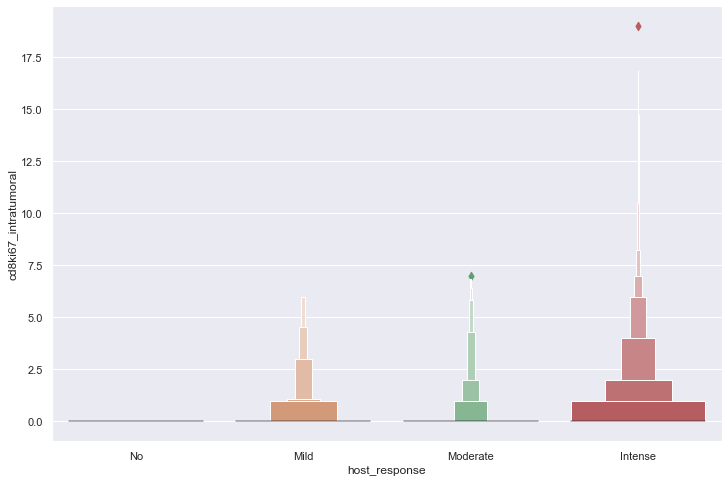

In [107]:
plot_box('cd8ki67_intratumoral','host_response')

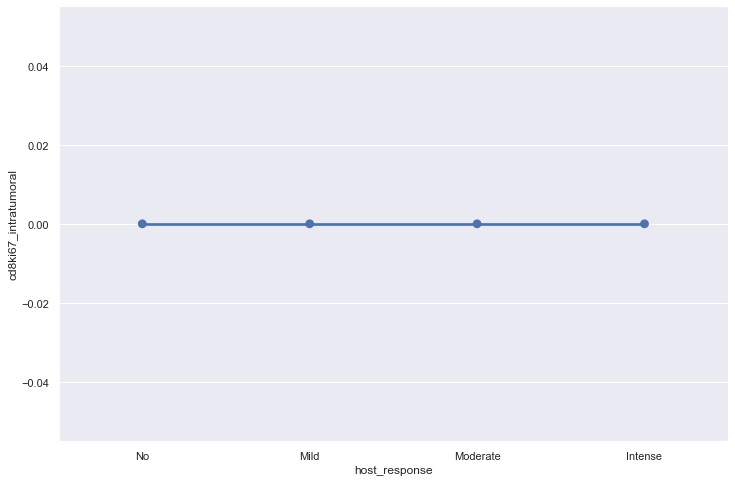

In [108]:
plot_point('cd8ki67_intratumoral','host_response')

In [109]:
do_kw('cd8ki67_intratumoral','host_response')

Kruskal-Wallis statistic: 23.5031
P value: 3.1717e-05


### CD8 in peritumoral lymphocytes

In [110]:
create_descriptives('cd8_peritumoral','host_response')

,count,mean,std,min,25%,50%,75%,max
host_response,,,,,,,,
No,3.0,6.0,11.0,0.0,0.0,0.0,10.0,19.0
Mild,88.0,9.0,13.0,0.0,0.0,4.0,12.0,64.0
Moderate,152.0,19.0,20.0,0.0,4.0,12.0,27.0,93.0
Intense,242.0,38.0,29.0,0.0,15.0,32.0,56.0,150.0


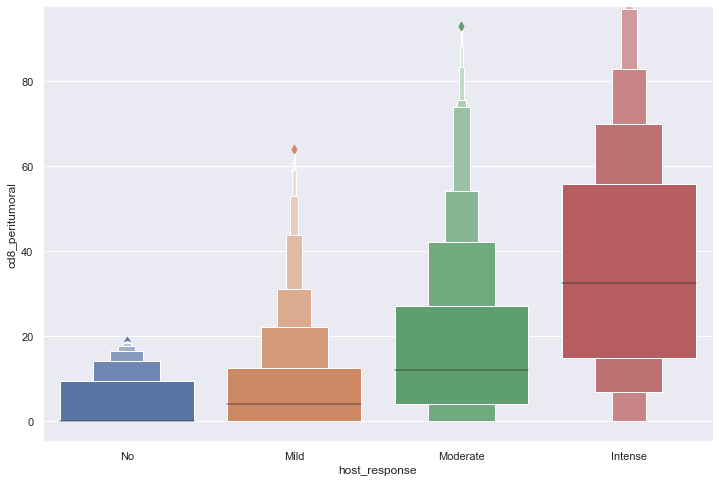

In [111]:
plot_box('cd8_peritumoral','host_response')

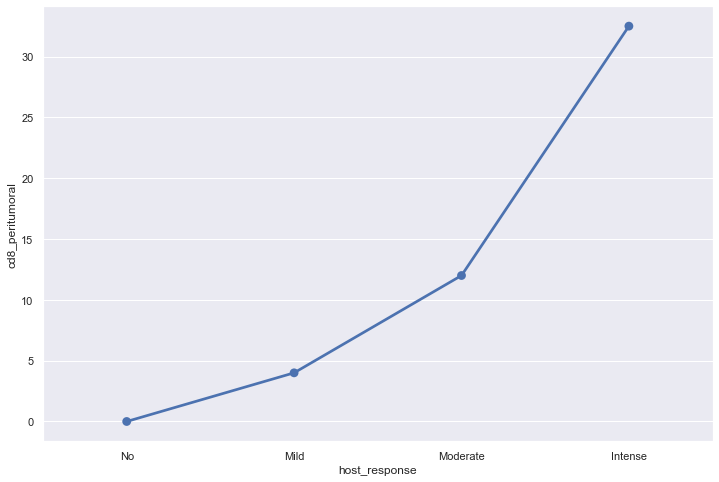

In [112]:
plot_point('cd8_peritumoral','host_response')

In [113]:
do_kw('cd8_peritumoral','host_response')

Kruskal-Wallis statistic: 115.481
P value: 7.25283e-25


### CD8-Ki67 in peritumoral lymphocytes

In [114]:
create_descriptives('cd8ki67_peritumoral','host_response')

,count,mean,std,min,25%,50%,75%,max
host_response,,,,,,,,
No,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mild,88.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
Moderate,151.0,0.0,1.0,0.0,0.0,0.0,0.0,17.0
Intense,242.0,1.0,2.0,0.0,0.0,0.0,1.0,23.0


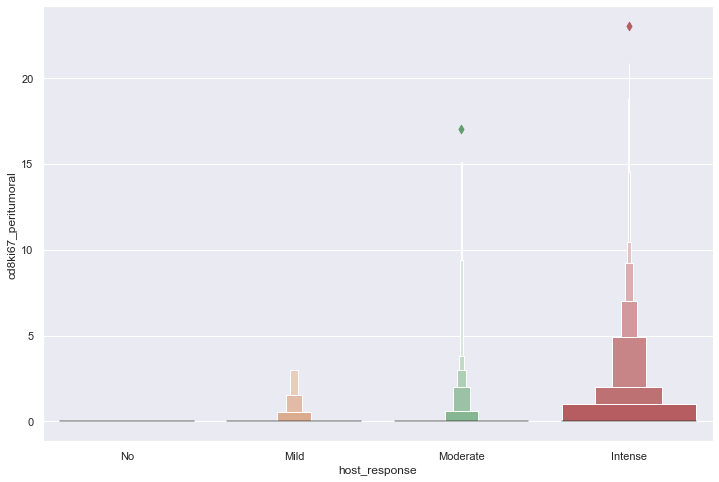

In [115]:
plot_box('cd8ki67_peritumoral','host_response')

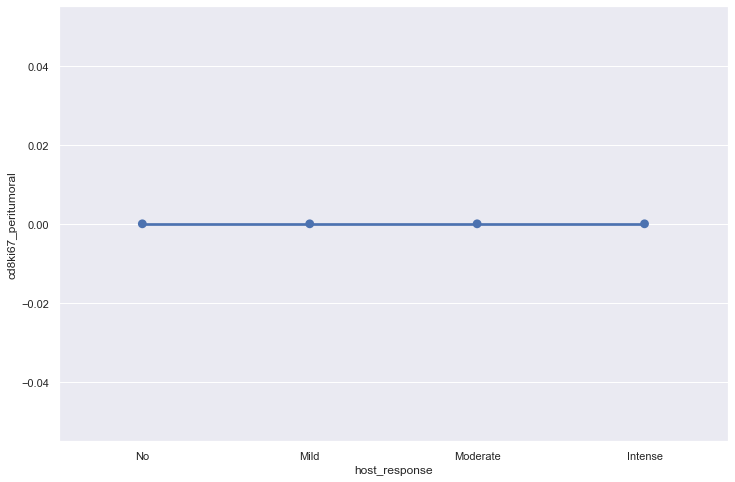

In [116]:
plot_point('cd8ki67_peritumoral','host_response')

In [117]:
do_kw('cd8ki67_peritumoral','host_response')

Kruskal-Wallis statistic: 37.4278
P value: 3.7357e-08


## Correlation matrix

In [118]:
vars = ['cd8_intratumoral','cd8ki67_intratumoral','cd8_peritumoral','cd8ki67_peritumoral']

### Pairplot

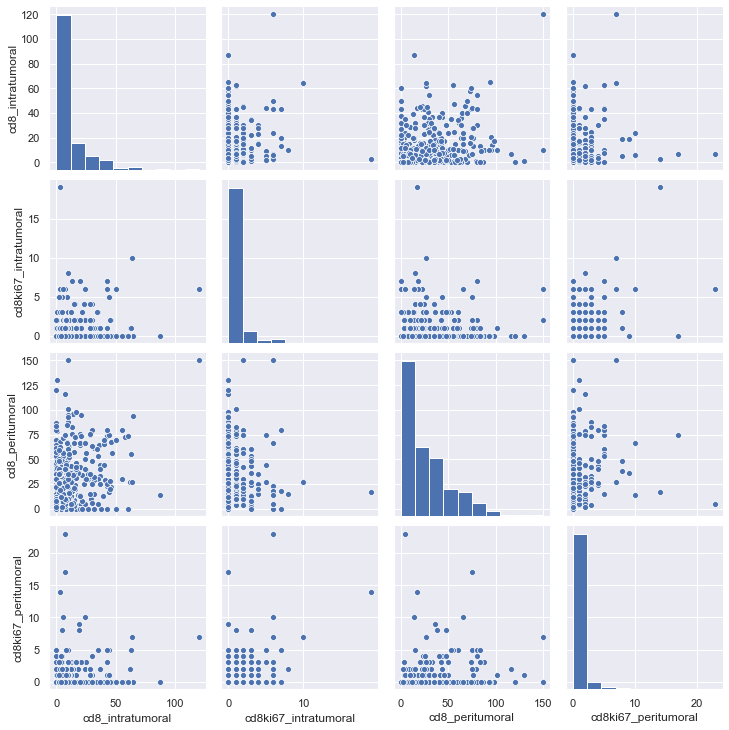

In [119]:
plot_pair(vars)

### Correlation coefficients

In [120]:
do_spearman_rho(vars)

,cd8_intratumoral,cd8ki67_intratumoral,cd8_peritumoral,cd8ki67_peritumoral
cd8_intratumoral,1.00,0.34,0.37,0.23
cd8ki67_intratumoral,0.34,1.00,0.13,0.54
cd8_peritumoral,0.37,0.13,1.00,0.24
cd8ki67_peritumoral,0.23,0.54,0.24,1.00


### P values

In [121]:
do_spearman_p(vars)

,cd8_intratumoral,cd8ki67_intratumoral,cd8_peritumoral,cd8ki67_peritumoral
cd8_intratumoral,0.000000e+00,4.455658e-15,2.030085e-17,1.307078e-07
cd8ki67_intratumoral,4.455658e-15,0.000000e+00,5.047091e-03,8.730021e-39
cd8_peritumoral,2.030085e-17,5.047091e-03,0.000000e+00,6.753710e-08
cd8ki67_peritumoral,1.307078e-07,8.730021e-39,6.753710e-08,0.000000e+00


## Impact of pathologic features

### CD8 in intratumoral lymphocytes

In [122]:
get_all_scores('cd8_intratumoral')

Variance explained by ['subtype']: 7.74533
Variance explained by ['grade']: -5.00625
Variance explained by ['host_response']: 15.0271
Variance explained by ['subtype', 'grade']: 5.3277
Variance explained by ['host_response', 'grade']: 11.1305
Variance explained by ['subtype', 'host_response']: 19.4128
Variance explained by ['subtype', 'grade', 'host_response']: 18.735


### CD8-Ki67 in intratumoral lymphocytes

In [123]:
get_all_scores('cd8ki67_intratumoral')

Variance explained by ['subtype']: 1.35337
Variance explained by ['grade']: -0.0832219
Variance explained by ['host_response']: -1.0574
Variance explained by ['subtype', 'grade']: 0.761449
Variance explained by ['host_response', 'grade']: -0.0975487
Variance explained by ['subtype', 'host_response']: 1.73479
Variance explained by ['subtype', 'grade', 'host_response']: 1.53531


### CD8 in peritumoral lymphocytes

In [124]:
get_all_scores('cd8_peritumoral')

Variance explained by ['subtype']: 0.352473
Variance explained by ['grade']: 0.151825
Variance explained by ['host_response']: 21.1009
Variance explained by ['subtype', 'grade']: -0.00935259
Variance explained by ['host_response', 'grade']: 22.9877
Variance explained by ['subtype', 'host_response']: 20.4234
Variance explained by ['subtype', 'grade', 'host_response']: 21.1611


### CD8-Ki67 in peritumoral lymphocytes

In [125]:
get_all_scores('cd8ki67_peritumoral')

Variance explained by ['subtype']: 50.4013
Variance explained by ['grade']: 1.71195
Variance explained by ['host_response']: 4.04579
Variance explained by ['subtype', 'grade']: 50.8232
Variance explained by ['host_response', 'grade']: 5.03423
Variance explained by ['subtype', 'host_response']: 52.2339
Variance explained by ['subtype', 'grade', 'host_response']: 52.3157
